In [1]:
import os
import pandas as pd
import warnings
import sys
sys.path.insert(0, '..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Hindcast_Initialization, FigureDeveloper
import hydroeval as he
import sklearn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#Set working directories
cwd = os.getcwd() 
datapath = f"{os.path.expanduser('~')}/SWEML"
warnings.filterwarnings("ignore")

In [2]:
import importlib
importlib.reload(FigureDeveloper)

<module 'shared_scripts.FigureDeveloper' from '/home/jovyan/SWEML/Model/Neural_Network/../shared_scripts/FigureDeveloper.py'>

In [3]:
#Get datetime and corresponding background information to evaluate hindcast
#Need to load predictions2022-09-24.h5, 2019_predictions.h5 (if straight to here and did not make predictions)  

new_year = '2019'
threshold = '10.0'
Region_list = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','Greater_Yellowstone', 
     'N_Co_Rockies', 'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade',
     'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies', 
     'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast',
     'Greater_Glacier', 'Or_Coast'
              ]

Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']
model = 'Neural_Network'
frequency = 'Daily'
fSCA = True

#if using daily, 345 locations from ASO not included in training data.
datelist = Hindcast_Initialization.Hindcast_Initialization(cwd, datapath, new_year, threshold, Region_list, frequency, fSCA = fSCA)
EvalDF, missingsites = Hindcast_Initialization.HindCast_DataProcess(datelist,Region_list, cwd, datapath, model, frequency, fSCA = fSCA)

Creating files for a historical simulation within  'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low', 'Greater_Yellowstone', 'N_Co_Rockies', 'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade', 'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies', 'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast', 'Greater_Glacier', 'Or_Coast'  regions for water year  2019
Getting prediction files
Site data processing complete, setting up prediction dataframes...
Finalizing Evaluation dataframes...
There were  0  sites missing from the prediction dataset occuring on  []


In [7]:
#Daily
FigureDeveloper.Peak_SWE(datelist, EvalDF, Region_list)

,ObsMax,PredMax,ObsMaxDate,PredMaxDate
Region,,,,
Northern Sierra Nevada,139.107333,137.497305,2019-04-02,2019-04-09
Southern Sierra Nevada High,133.996545,138.318186,2019-04-09,2019-04-02
Southern Sierra Nevada Low,100.838,90.504902,2019-03-26,2019-02-26
Greater Yellowstone,30.674235,39.785925,2019-04-16,2019-04-09
Upper Colorado Rockies,51.107474,46.347273,2019-04-16,2019-03-26
SW Montana,46.0756,53.576808,2019-04-16,2019-04-16
San Juan Mountains,55.372,56.490532,2019-04-02,2019-04-16
Great Basin,46.455263,51.142788,2019-03-26,2019-03-19
Northern Wasatch,61.896625,67.548955,2019-04-16,2019-05-14


In [8]:
#Daily
Model_Results = FigureDeveloper.Dict_2_DF(EvalDF, Region_list)
Model_Results.head()

,y_test,y_pred,Region,Date,Long,Lat,elevation_m,WYWeek,northness,VIIRS_SCA,hasSnow,y_pred_fSCA,error
00c4db22-a423-41a4-ada6-a8b1b04153a4,6.858,8.897948,Northern Sierra Nevada,2018-12-11,-121.939413,41.166647,1661.50,10.0,-0.167901,55.500000,True,8.897948,-2.039948
018cf1a1-f945-4097-9c47-0c4690538bb5,17.780,13.913171,Northern Sierra Nevada,2018-12-11,-120.618890,39.675880,2057.50,10.0,-0.006909,55.500000,True,13.913171,3.866829
147d5eb4-e574-47e4-994a-8a2908c06050,11.176,12.654386,Northern Sierra Nevada,2018-12-11,-120.879401,39.786417,2013.00,10.0,0.011996,70.166667,True,12.654386,-1.478386
6dd37e24-0a9c-4749-8ab6-7e26d42925d6,10.160,8.225610,Northern Sierra Nevada,2018-12-11,-121.786700,40.780052,1787.00,10.0,-0.191108,56.500000,True,8.225610,1.934390
76b55900-eb3d-4d25-a538-f74302ffe72d,15.494,22.444531,Northern Sierra Nevada,2018-12-11,-120.178716,41.993149,2261.25,10.0,0.039906,100.000000,True,22.444531,-6.950531


# Daily

In [9]:
#put all regions together for basic metrics
allregions = pd.DataFrame()
for region in EvalDF.keys():
    allregions = pd.concat([allregions, EvalDF[region]])
    
y_pred = allregions['y_pred_fSCA']
y_test = allregions['y_test']
    
kge, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
pbias = he.evaluator(he.pbias, y_pred, y_test)


print('There are ', len(allregions), ' hindcast evaluation obs')
print('All regions KGE is: ', kge[0])
print('All regions rmse is: ', rmse)
print('All regions pbias is: ', pbias[0])

There are  6221  hindcast evaluation obs
All regions KGE is:  0.8608337248310781
All regions rmse is:  15.410228777972765
All regions pbias is:  0.706073330789847


In [10]:
#Daily
Maritime_Region, Prairie_Region, Alpine_Region, Snow_Class = FigureDeveloper.Sturm_Classified_Performance(Model_Results)

Maritime  RMSE:  21.720078150366326  R2:  0.7830899747043261 pbias: [3.07801107] KGE:  0.8592048834110146
Alpine  RMSE:  11.909382654991218  R2:  0.7293442230575824 pbias: [-1.00234947] KGE:  0.8282568494073429
Prairie  RMSE:  10.990974574580013  R2:  0.7482587454803897 pbias: [-0.64285778] KGE:  0.8703129217573107


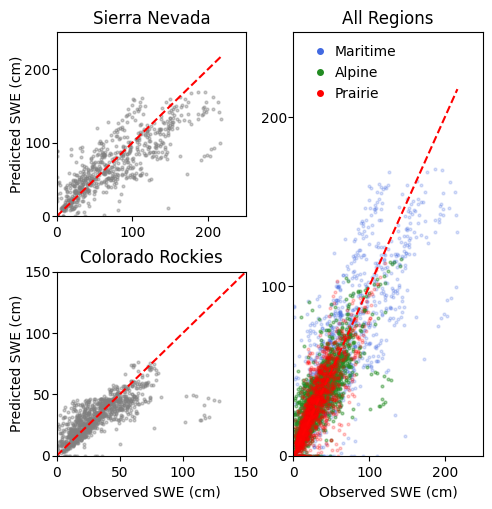

In [8]:
#Daily
FigureDeveloper.Slurm_Class_parity(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region, frequency)

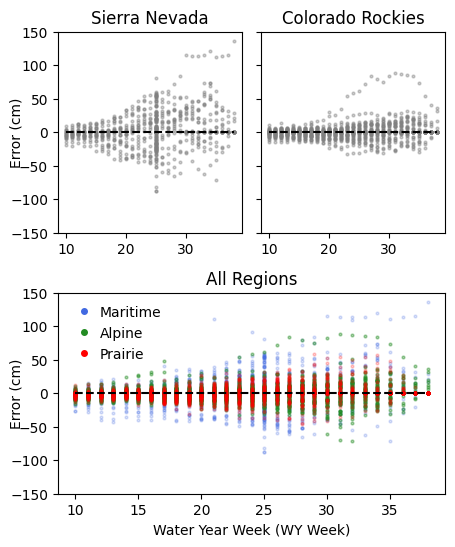

In [10]:
#Daily
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region, 'WYWeek', 'error', 'Water Year Week (WY Week)', 'Error (cm)', 'ErrorVsWYWeek', 2, frequency)

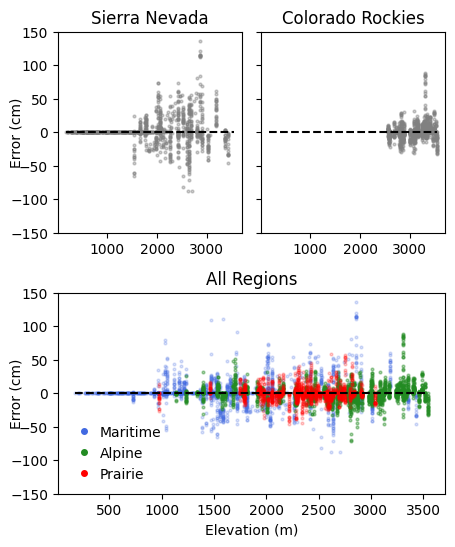

In [11]:
#Daily
FigureDeveloper.EvalPlots3(Model_Results, Maritime_Region, Prairie_Region, Alpine_Region,'elevation_m', 'error', 'Elevation (m)', 'Error (cm)', 'ErrorVsElevation', 2, frequency)

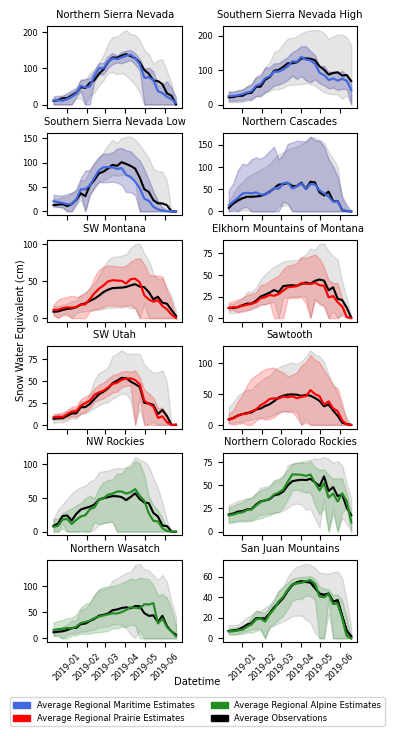

In [26]:
#Daily

Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']


importlib.reload(FigureDeveloper)

Maritime = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','N_Cascade']
Prarie = [ 'SW_Mont', 'N_Yellowstone', 'S_Wasatch','Sawtooth']
Alpine = [ 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'N_Wasatch','SW_Co_Rockies']

plotname = 'All_Regions_TS'
save = True
RegionDict, RegionAll = FigureDeveloper.SWE_TS_plot_classes(datelist, EvalDF, Maritime, Prarie, Alpine, plotname, fontsize = 6, opacity=0.1, frequency = 'Daily', save = save)

['Northern Sierra Nevada', 'Southern Sierra Nevada High', 'Southern Sierra Nevada Low', 'Southern Cascades', 'SW Montana', 'Great Basin', 'SW Utah', 'Sawtooth', 'NW Rockies', 'Northern Colorado Rockies', 'Northern Wasatch', 'Upper Colorado Rockies']


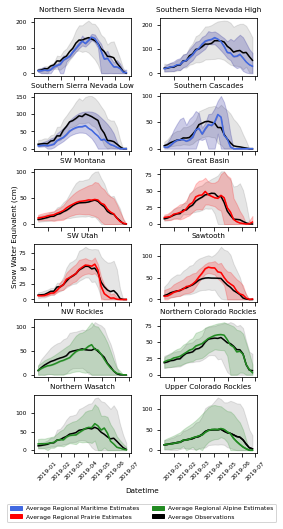

In [178]:
#Weekly

importlib.reload(FigureDeveloper)

Maritime = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low','S_Cascade']
Prarie = [ 'SW_Mont', 'GBasin', 'S_Wasatch','Sawtooth']
Alpine = [ 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'N_Wasatch','N_Co_Rockies']

plotname = 'All_Regions_TS'
RegionDict, RegionAll = FigureDeveloper.SWE_TS_plot_classes(datelist, EvalDF, Maritime, Prarie, Alpine, plotname, fontsize = 6, opacity=0.1)


processing predictions into geodataframe


100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


creating figures for each prediction timestep


  0%|          | 0/1 [00:00<?, ?it/s]

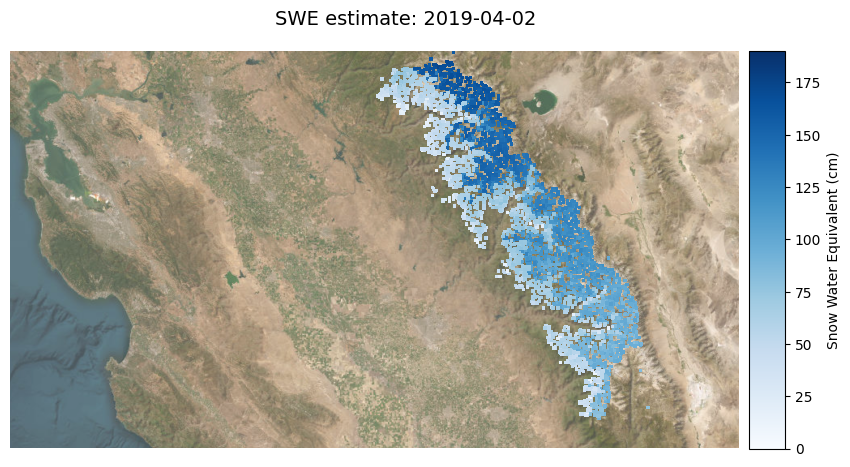

  0%|          | 0/1 [00:14<?, ?it/s]


In [17]:

importlib.reload(FigureDeveloper)
Region_list = [ 'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low']
#Get list of optional tiles here: https://contextily.readthedocs.io/en/latest/providers_deepdive.html
variant = 'World_Imagery'#   'World_Physical_Map'
date = ["2019-04-02"]
plotdf = FigureDeveloper.SSM_Fig(date, Region_list,variant,  frequency, fSCA)

In [20]:
for my_bucket_object in BUCKET.objects.filter(Prefix="SNODAS"):
    print(my_bucket_object.key)

SNODAS/
SNODAS/SNODAS_WY2019.pkl
SNODAS/SSierrasHigh3242019_SNODAS.csv
SNODAS/SSierrasHigh3242019sites.csv
SNODAS/SSierrasLow3242019_SNODAS.csv
SNODAS/SSierrasLow3242019sites.csv


In [21]:
key = f"SNODAS/SNODAS_WY2019.pkl"            
S3.meta.client.download_file(BUCKET_NAME, key,'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2019.pkl')

In [23]:
SNODAS = pd.read_pickle(r'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2019.pkl')

In [ ]:
s = 

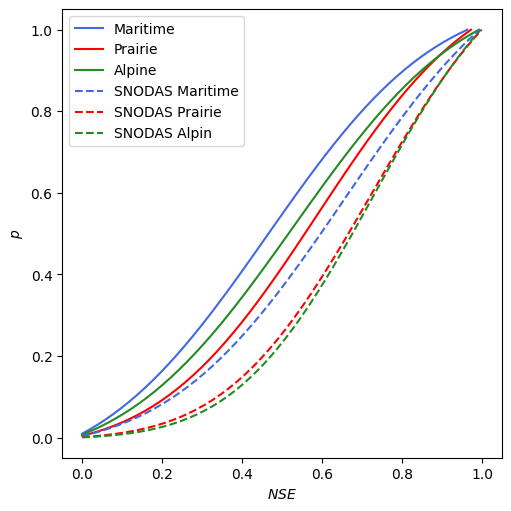

In [4]:
importlib.reload(FigureDeveloper)
#make snow class cdfs
Maritime_Region = ['S_Sierras_High','S_Sierras_Low', 'N_Sierras','S_Cascade',
                      'N_Cascade', 'Ca_Coast', 'Wa_Coast', 
                      'Or_Coast']

Prairie_Region  =  ['N_Yellowstone','SW_Mont', 'GBasin', 'S_Wasatch', 'Sawtooth', 'SW_Mtns']

Alpine_Region =['E_Or', 'N_Wasatch', 'E_WA_N_Id_W_Mont', 'Greater_Yellowstone', 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies',
                        'Greater_Glacier', 'SE_Co_Rockies']

#read in SNODAS pickle
SNODAS = pd.read_pickle(r'Predictions/Hold_Out_Year/SNODAS/SNODAS_WY2019.pkl')

#remove lat/long
for region in SNODAS.keys():
    SNODAS[region].pop('Long')
    SNODAS[region].pop('Lat')

SNODAS_MaritimeNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Maritime_Region)
SNODAS_PrarieNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Prairie_Region)
SNODAS_AlpineNSE = FigureDeveloper.SNODASslurmNSE(EvalDF, SNODAS, Alpine_Region)

MaritimeNSE = FigureDeveloper.slurmNSE(EvalDF, Maritime_Region)
PrarieeNSE = FigureDeveloper.slurmNSE(EvalDF, Prairie_Region)
AlpineNSE = FigureDeveloper.slurmNSE(EvalDF, Alpine_Region)

FigureDeveloper.regionCDF(MaritimeNSE, PrarieeNSE, AlpineNSE, SNODAS_MaritimeNSE, SNODAS_PrarieNSE, SNODAS_AlpineNSE, SNODAS=True, plt_save = True)

## Evaluate spatial performance of model

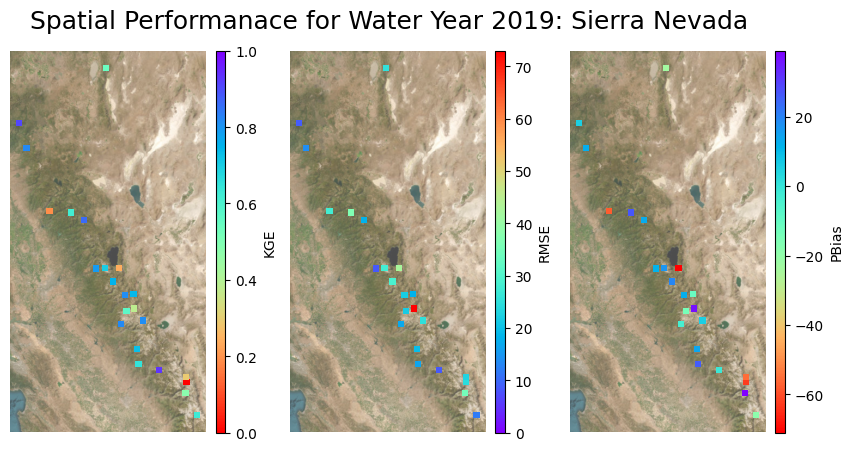

In [50]:
importlib.reload(FigureDeveloper)
Region_list = ['S_Sierras_Low', 'S_Sierras_High', 'N_Sierras']
metric = 'KGE'
fequency = 'Daily'
fSCA = True
plot_x_titloc = -1.355e7
plot_y_titloc = 5.25e6
save = True
variant = 'World_Imagery'# 
model = 'Neural Network'
plotname =  f"Spatial Performanace for Water Year 2019: Sierra Nevada"
plotdf = FigureDeveloper.SpatialPerf_Fig(Region_list,EvalDF, variant,  frequency, fSCA, plotname, plot_x_titloc, plot_y_titloc, save, model)

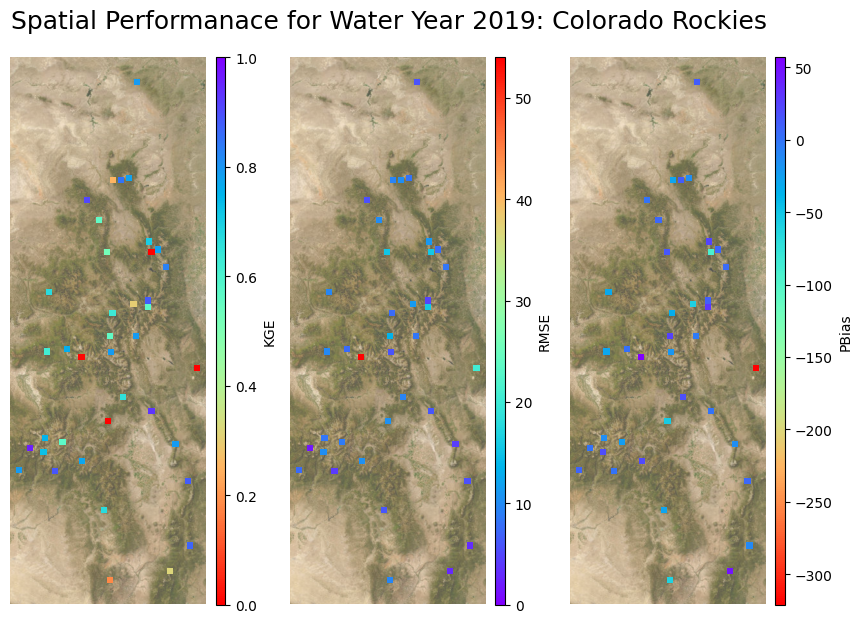

In [57]:
importlib.reload(FigureDeveloper)
Region_list =[ 'N_Co_Rockies','S_Wyoming', 'SW_Co_Rockies', 'SE_Co_Rockies']
metric = 'KGE'
fequency = 'Daily'
fSCA = True
plot_x_titloc = -1.205e7
plot_y_titloc = 5.35e6
save = True
variant = 'World_Imagery'# 
model = 'Neural Network'
plotname =  f"Spatial Performanace for Water Year 2019: Colorado Rockies"
plotdf = FigureDeveloper.SpatialPerf_Fig(Region_list,EvalDF, variant,  frequency, fSCA, plotname, plot_x_titloc,plot_y_titloc , save, model)

## Evaluate to ASO obs

R2:  0.73  RMSE:  16.59  KGE:  0.76  PBias:  2.49


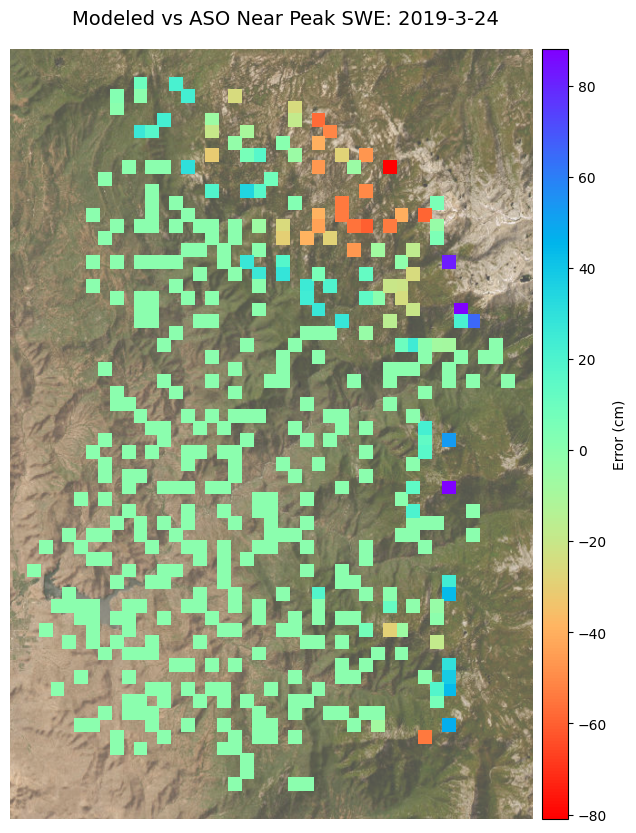

In [7]:
importlib.reload(FigureDeveloper)
ASOregions = ['S_Sierras_High', 'S_Sierras_Low']
plotname = 'Modeled vs ASO Near Peak SWE: 2019-3-24'
model = 'Nerual_Network'
plot_x_dim = -1.3245e7
variant = 'World_Imagery'# 
metric = 'KGE'
fequency = 'Daily'
save = False
FigureDeveloper.ASOError_Fig(ASOregions,EvalDF, variant,  frequency, fSCA, metric, model, plotname, plot_x_dim, save)

In [9]:
importlib.reload(FigureDeveloper)
ASOregions = ['S_Sierras_High', 'S_Sierras_Low']
plotname = 'SNODAS vs ASO Near Peak SWE: 2019-3-24'
model = 'Nerual_Network'
plot_x_dim = -1.3245e7
variant = 'World_Imagery'# 
metric = 'KGE'
fequency = 'Daily'
save = False
FigureDeveloper.ASOError_Fig(ASOregions,SNODAS, variant,  frequency, fSCA, metric, model, plotname, plot_x_dim, save)

KeyError: "None of [Index(['Date', 'Long', 'Lat', 'y_pred', 'y_test'], dtype='object')] are in the [columns]"

In [25]:
SNODAS['S_Sierras_High']

,Long,Lat,2018-10-02,2018-10-09,2018-10-16,2018-10-23,2018-10-30,2018-11-06,2018-11-13,2018-11-20,...,2019-04-23,2019-04-30,2019-05-07,2019-05-14,2019-05-21,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25
cell_id,,,,,,,,,,,,,,,,,,,,,
00146204-d4e9-4cd8-8f86-d1ef133c5b6d,-118.525815,36.660957,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,1.154,0.994,0.866,0.728,0.660,0.663,0.505,0.310,0.097,0.000
00656c12-2000-4cb7-97b0-6d51bafb5db2,-118.552765,37.070609,0.0,0.008,0.001,0.0,0.0,0.0,0.0,0.0,...,0.663,0.591,0.516,0.483,0.508,0.525,0.511,0.292,0.029,0.000
0075950a-3452-49a7-a1d7-7fb71b984696,-119.990069,38.813228,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,1.014,0.732,0.534,0.361,0.388,0.441,0.277,0.000,0.000,0.000
00802ec7-1ff4-4432-8cad-8a2db176f2bd,-119.882271,38.750204,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.951,0.727,0.606,0.419,0.379,0.389,0.148,0.000,0.000,0.000
0095d99e-2c21-40ff-bb09-467a12da25d2,-119.046838,37.577798,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,1.096,0.884,0.671,0.509,0.551,0.587,0.462,0.179,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff8a5f48-d8f6-44f1-90ac-b5adb7bead0e,-118.615647,36.840899,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,1.255,1.155,1.037,0.925,0.917,0.944,0.906,0.674,0.347,0.042
ff8c4a7d-9d41-4e2b-b8db-523ff5304ddd,-119.504979,37.819463,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,1.679,1.570,1.401,1.187,1.177,1.243,1.052,0.796,0.605,0.252
ffb6d015-cb93-4ba3-ab9a-953d31a82bbb,-118.391068,36.790558,0.0,0.006,0.000,0.0,0.0,0.0,0.0,0.0,...,0.410,0.334,0.306,0.284,0.300,0.317,0.251,0.141,0.000,0.000
